## Import

In [1]:
import mne
import numpy as np
import os
from scipy import signal as sg
from mne.preprocessing import read_ica
from mne_icalabel import label_components
import asrpy

c:\Users\jeje_\anaconda3\envs\mne-label\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Define Folder Name - NEED MODIFICATION DEPENDING ON THE SUBJECT

In [2]:
fpath = "20231019_B68_stroop5mins/20231019_B68_stroop5mins_0001.vhdr"

Define save directories

In [3]:
folder_name, file_name = os.path.split(fpath)
folder_epoch_asr = "hep_asr"
folder_epoch_eog = "hep_eog"
folder_epoch_cfa = "hep_eog_cfa"
folder_filtered_asr = "filtered_data_asr"
folder_filtered_eog = "filtered_data_ica_eog"
folder_filtered_cfa = "filtered_data_ica_eog_cfa"

## Load Data

In [10]:
directory_path = "D:/EEG RESEARCH DATA"
os.chdir(directory_path)
raw = mne.io.read_raw_brainvision(fpath)
raw.load_data()

# Reconstruct the original events from our Raw object
events, event_ids = mne.events_from_annotations(raw)

montage = mne.channels.make_standard_montage('standard_1020')
raw.set_channel_types({'ECG':'ecg'})
raw.set_channel_types({'vEOG':'eog'})
raw.set_channel_types({'hEOG':'eog'})

raw.set_montage(montage)

Extracting parameters from 20231019_B68_stroop5mins/20231019_B68_stroop5mins_0001.vhdr...
Setting channel info structure...
Reading 0 ... 958599  =      0.000 ...   958.599 secs...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1']


<RawBrainVision | 20231019_B68_stroop5mins_0001.eeg, 67 x 958600 (958.6 s), ~490.1 MB, data loaded>

## Segment Grouping - NEED MODIFICATION DEPENDING ON THE SUBJECT

In [5]:
fs = 1000

trg0 = events[9,0] #Experiment Begin 
trg1 = events[10,0] #Task Begin
trg2 = events[-2,0] #Task End
trg3 = events[-1,0] #Experiment End

tmin = trg0/fs
tmax = trg3/fs

############################### Segment Grouping for EEG ###############################
#Segment in Samples
eeg_seg1 = trg1 - trg0
eeg_seg2 = trg2 - trg0
eeg_seg3 = trg3 - trg0

#Segment in ms
eeg_newseg1 = eeg_seg1/fs
eeg_newseg2 = eeg_seg2/fs
eeg_newseg3 = eeg_seg3/fs
############################### Segment Grouping for EEG ###############################

## Utilities

In [6]:
class pan_tompkins_qrs():
    def bpf(self,x):
        
        y_filtered = None
        
        # x = np.squeeze(x)
        #Results will be delayed 16 Samples
        y = x.copy()

        #Low Pass Filter
        #y(n) = 2y(n-1) - y(n-2) + x(n) - 2x(n-6) + x(n-12)
        for n in range(len(x)):
            y[n] = x[n]

            if (n >= 1):
                y[n] += 2*y[n-1]
            if (n >= 2):
                y[n] -= y[n-2]
            if (n >= 6):
                y[n] -= 2*x[n-6]
            if (n >= 12):
                y[n] += x[n-12]
        
        y_filtered = y.copy()

        #High Pass Filter
        #y(n) = 32x(n-16) - y(n-1) - x(n) + x(n-32)
        for n in range(len(x)):
            y_filtered[n] = -1*y[n]

            if (n >= 1):
                y_filtered[n] -= y_filtered[n-1]
            if (n >= 16):
                y_filtered[n] += 32*y[n-16]
            if(n >= 32):
                y_filtered[n] += y[n-32]
        
        #Normalization
        max_val = max(max(y_filtered), -min(y_filtered))
        y_filtered = y_filtered/max_val

        return y_filtered
    
    def derivative(self,x,fs):
        
        #Results will be delayed for 2 samples
        y_derived = x.copy()
        
        #Derivative Filter
        #y(n) = [-x(n-2) - 2x(n-1) + 2x(n+1) + x(n+2)]/8
        for n in range(len(x)):
            y_derived[n] = 0

            if (n >= 1):
                y_derived[n] -= 2*x[n-1]
            if (n >= 2):
                y_derived[n] -= x[n-2]
            
            ###For this part [2x(n+1) + x(n+2)]###
            if (n >= 2 and n <= len(x)-2):
                y_derived[n] += 2*x[n+1]
            if (n >= 2 and n<= len(x)-3):
                y_derived[n] += x[n+2]
            ###For this part [2x(n+1) + x(n+2)]###

            ###In trasnfer function times 1/T, change to times fs###
            y_derived[n] = (y_derived[n]*fs)/8
            ###In trasnfer function times 1/T, change to times fs###
        
        return y_derived
    
    def squaring(self,x):
        
        y_squared = x.copy()

        for n in range(len(x)):
            y_squared[n] = x[n]**2

        return y_squared
    
    def moving_window_integration(self,x,fs):
        # Initialize result and window size for integration
        y = x.copy()
        win_size = round(0.150 * fs)
        sum = 0

        # Calculate the sum for the first N terms
        for j in range(win_size):
            sum += x[j]/win_size
            y[j] = sum
        
        # Apply the moving window integration using the equation given
        for n in range(win_size,len(x)):  
            sum += x[n]/win_size
            sum -= x[n-win_size]/win_size
            y[n] = sum

        return y

    def solve(self,x,fs):

        # Convert the input signal into numpy array
        input_signal = x.copy()

        # Bandpass Filter
        global bpass
        bpass = self.bpf(input_signal)

        # Derivative Function
        global der
        der = self.derivative(bpass,fs)

        # Squaring Function
        global sqr
        sqr = self.squaring(der)

        # Moving Window Integration Function
        global mwin
        mwin = self.moving_window_integration(sqr,fs)

        return mwin


In [7]:
class heart_rate():
    def __init__(self,x,fs):
        #Initialize Variables
        self.RR1, self.RR2, self.probable_peaks, self.r_locs, self.peaks, self.result = ([] for i in range(6))
        self.SPKI, self.NPKI, self.Threshold_I1, self.Threshold_I2, self.SPKF, self.NPKF, self.Threshold_F1, self.Threshold_F2 = (0 for i in range(8))

        self.T_wave = False
        self.m_win = mwin
        self.b_pass = bpass
        self.fs = fs
        # self.signal = np.squeeze(x)
        self.signal = x
        self.win_150ms = round(0.15*self.fs)

        self.RR_Low_Limit = 0
        self.RR_High_Limit = 0
        self.RR_Missed_Limit = 0
        self.RR_Average1 = 0

    def approx_peak(self):
        slopes = sg.fftconvolve(self.m_win, np.full((25,),1)/25, mode='same')

        # for i in range(round(0.5*self.fs) + 1,len(slopes)-1):
        for i in range(0,len(slopes)-1):
            if (slopes[i] > slopes[i-1]) and (slopes[i+1] <slopes[i]):
                self.peaks.append(i)

    def adjust_rr_interval(self, ind):
        self.RR1 = np.diff(self.peaks[max(0,ind - 8) : ind + 1])/self.fs  

        # Calculating RR Averages
        self.RR_Average1 = np.mean(self.RR1)
        RR_Average2 = self.RR_Average1
        
        # Finding the eight most recent RR intervals lying between RR Low Limit and RR High Limit  
        if (ind >= 8):
            for i in range(0, 8):
                if (self.RR_Low_Limit < self.RR1[i] < self.RR_High_Limit): 
                    self.RR2.append(self.RR1[i])

                    if (len(self.RR2) > 8):
                        self.RR2.remove(self.RR2[0])
                        RR_Average2 = np.mean(self.RR2)    

        # Adjusting the RR Low Limit and RR High Limit
        if (len(self.RR2) > 7 or ind < 8):
            self.RR_Low_Limit = 0.92 * RR_Average2        
            self.RR_High_Limit = 1.16 * RR_Average2
            self.RR_Missed_Limit = 1.66 * RR_Average2
    
    def searchback(self, peak_val, RRn, sb_win):
        # Check if the most recent RR interval is greater than the RR Missed Limit
        if (RRn > self.RR_Missed_Limit):
            # Initialize a window to searchback  
            win_rr = self.m_win[peak_val - sb_win + 1 : peak_val + 1] 

            # Find the x locations inside the window having y values greater than Threshold I1             
            coord = np.asarray(win_rr > self.Threshold_I1).nonzero()[0]

            # Find the x location of the max peak value in the search window
            if (len(coord) > 0):
                for pos in coord:
                    if (win_rr[pos] == max(win_rr[coord])):
                        x_max = pos
                        break
            else:
                x_max = None
    
            # If the max peak value is found
            if (x_max is not None):   
                # Update the thresholds corresponding to moving window integration
                self.SPKI = 0.25 * self.m_win[x_max] + 0.75 * self.SPKI                         
                self.Threshold_I1 = self.NPKI + 0.25 * (self.SPKI - self.NPKI)
                self.Threshold_I2 = 0.5 * self.Threshold_I1         

                # Initialize a window to searchback 
                win_rr = self.b_pass[x_max - self.win_150ms: min(len(self.b_pass) -1, x_max)]  

                # Find the x locations inside the window having y values greater than Threshold F1                   
                coord = np.asarray(win_rr > self.Threshold_F1).nonzero()[0]

                # Find the x location of the max peak value in the search window
                if (len(coord) > 0):
                    for pos in coord:
                        if (win_rr[pos] == max(win_rr[coord])):
                            r_max = pos
                            break
                else:
                    r_max = None

                # If the max peak value is found
                if (r_max is not None):
                # Update the thresholds corresponding to bandpass filter
                    if self.b_pass[r_max] > self.Threshold_F2:                                                        
                        self.SPKF = 0.25 * self.b_pass[r_max] + 0.75 * self.SPKF                            
                        self.Threshold_F1 = self.NPKF + 0.25 * (self.SPKF - self.NPKF)
                        self.Threshold_F2 = 0.5 * self.Threshold_F1      

                        # Append the probable R peak location                      
                        self.r_locs.append(r_max)

    def find_t_wave(self,peak_val,RRn,ind,prev_ind):
        '''
        T Wave Identification
        :param peak_val: peak location in consideration
        :param RRn: the most recent RR interval
        :param ind: current index in peaks array
        :param prev_ind: previous index in peaks array
        '''

        if (self.m_win[peak_val] >= self.Threshold_I1): 
            if (ind > 0 and 0.20 < RRn < 0.36):
                # Find the slope of current and last waveform detected        
                curr_slope = max(np.diff(self.m_win[peak_val - round(self.win_150ms/2) : peak_val + 1]))
                last_slope = max(np.diff(self.m_win[self.peaks[prev_ind] - round(self.win_150ms/2) : self.peaks[prev_ind] + 1]))
            
                # If current waveform slope is less than half of last waveform slope
                if (curr_slope < 0.5*last_slope):  
                    # T Wave is found and update noise threshold                      
                    self.T_wave = True                             
                    self.NPKI = 0.125 * self.m_win[peak_val] + 0.875 * self.NPKI 

            if (not self.T_wave):
                # T Wave is not found and update signal thresholds
                if (self.probable_peaks[ind] > self.Threshold_F1):   
                    self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI                                         
                    self.SPKF = 0.125 * self.b_pass[ind] + 0.875 * self.SPKF 

                    # Append the probable R peak location
                    self.r_locs.append(self.probable_peaks[ind])  

                else:
                    self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI
                    self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF                   

        # Update noise thresholds
        elif (self.m_win[peak_val] < self.Threshold_I1) or (self.Threshold_I1 < self.m_win[peak_val] < self.Threshold_I2):
            self.NPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.NPKI  
            self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF


    def adjust_thresholds(self,peak_val,ind):
        '''
        Adjust Noise and Signal Thresholds During Learning Phase
        :param peak_val: peak location in consideration
        :param ind: current index in peaks array
        '''

        if (self.m_win[peak_val] >= self.Threshold_I1): 
            # Update signal threshold
            self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI

            if (self.probable_peaks[ind] > self.Threshold_F1):                                            
                self.SPKF = 0.125 * self.b_pass[ind] + 0.875 * self.SPKF 

                # Append the probable R peak location
                self.r_locs.append(self.probable_peaks[ind])  

            else:
                # Update noise threshold
                self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF                                    
            
        # Update noise thresholds    
        elif (self.m_win[peak_val] < self.Threshold_I2) or (self.Threshold_I2 < self.m_win[peak_val] < self.Threshold_I1):
            self.NPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.NPKI  
            self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF


    def update_thresholds(self):
        '''
        Update Noise and Signal Thresholds for next iteration
        '''

        self.Threshold_I1 = self.NPKI + 0.25 * (self.SPKI - self.NPKI)
        self.Threshold_F1 = self.NPKF + 0.25 * (self.SPKF - self.NPKF)
        self.Threshold_I2 = 0.5 * self.Threshold_I1 
        self.Threshold_F2 = 0.5 * self.Threshold_F1
        self.T_wave = False 


    def ecg_searchback(self):
        '''
        Searchback in ECG signal to increase efficiency
        '''

        # Filter the unique R peak locations
        self.r_locs = np.unique(np.array(self.r_locs).astype(int))
        
        # Initialize a window to searchback
        win_200ms = round(0.2*self.fs)
    
    
    
        for r_val in self.r_locs:
            
            coord = np.arange(r_val - win_200ms, min(len(self.signal), r_val + win_200ms + 1), 1)
            
            # Find the x location of the max peak value
            if (len(coord) > 0):
                for pos in coord:               
                    if (self.signal[pos] == max(self.signal[coord])):
                        x_max = pos
                        break
            else:
                x_max = None

            # Append the peak location
            if (x_max is not None):   
                self.result.append(x_max)


    def find_r_peaks(self):
        '''
        R Peak Detection
        '''

        # Find approximate peak locations
        self.approx_peak()

        # Iterate over possible peak locations
        for ind in range(len(self.peaks)):

            # Initialize the search window for peak detection
            peak_val = self.peaks[ind]
            win_300ms = np.arange(max(0, self.peaks[ind] - self.win_150ms), min(self.peaks[ind] + self.win_150ms, len(self.b_pass)-1), 1)
            max_val = max(self.b_pass[win_300ms], default = 0)

            # Find the x location of the max peak value
            if (max_val != 0):        
                x_coord = np.asarray(self.b_pass == max_val).nonzero()
                self.probable_peaks.append(x_coord[0][0])
                
            if (ind < len(self.probable_peaks) and ind != 0):
                # Adjust RR interval and limits
                self.adjust_rr_interval(ind)
                
                # Adjust thresholds in case of irregular beats
                if (self.RR_Average1 < self.RR_Low_Limit or self.RR_Average1 > self.RR_Missed_Limit): 
                    self.Threshold_I1 /= 2
                    self.Threshold_F1 /= 2

                RRn = self.RR1[-1]

                # Searchback
                self.searchback(peak_val,RRn,round(RRn*self.fs))

                # T Wave Identification
                self.find_t_wave(peak_val,RRn,ind,ind-1)

            else:
                # Adjust threholds
                self.adjust_thresholds(peak_val,ind)

            # Update threholds for next iteration
            self.update_thresholds()

        # Searchback in ECG signal 
        self.ecg_searchback()

        return np.unique(self.result)


In [7]:
def extract_eeg_ica(signal = raw, tmin = tmin, tmax = tmax, fpath = fpath):
    raw_temp = signal.copy().crop(tmin = tmin, tmax = tmax) #make a copy
    raw_temp.load_data()

    ica = read_ica(fname=fpath.replace(".vhdr", "-ica.fif"))

    filt_raw = raw_temp.load_data().copy().filter(l_freq=1.0, h_freq=100).set_eeg_reference(ref_channels='average')

    ic_labels = label_components(filt_raw, ica, method="iclabel")
    print(ic_labels["labels"])

    labels = ic_labels["labels"]
    eog_indices = [idx for idx, label in enumerate(labels) if label in ["eye blink"]]
    eog_cfa_indices = [idx for idx, label in enumerate(labels) if label in ["eye blink","heart beat"]]

    if "heart beat" not in labels:
        print("No CFA Detected in %s" % file_name)

    ica.exclude = eog_indices
    reconst_raw_eog = filt_raw.copy()
    ica.apply(reconst_raw_eog)

    ica.exclude = eog_cfa_indices
    reconst_raw_cfa = filt_raw.copy()
    ica.apply(reconst_raw_cfa)
    
    reconst_raw_eog.save(os.path.join(folder_filtered_eog,file_name.replace(".vhdr", "-ica.fif")), overwrite=True)
    reconst_raw_cfa.save(os.path.join(folder_filtered_cfa,file_name.replace(".vhdr", "-ica.fif")), overwrite=True)

In [7]:
def extract_eeg_asr(signal=raw,tmin=tmin,tmax=tmax, cutoff= 5):
    raw_asr = signal.copy().crop(tmin = tmin, tmax = tmax).pick_types(eeg=True, ecg=False, eog=False).filter(l_freq=1.0, h_freq=40, picks = ['eeg'])#make a copy

    asr = asrpy.ASR(sfreq=raw_asr.info["sfreq"], cutoff=cutoff)
    asr.fit(raw_asr)
    raw_asr = asr.transform(raw_asr)

    return(raw_asr)
    # raw_asr.save(os.path.join(folder_filtered_asr,file_name.replace(".vhdr", "-asr.fif")), overwrite=True)

## EEG Data - ICA Method

In [8]:
extract_eeg_ica(raw,tmin,tmax,fpath)

Reading 20231019_B68_stroop5mins/20231019_B68_stroop5mins_0001-ica.fif ...
Now restoring ICA solution ...
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
['eye blink', 'heart beat', 'eye blink', 'brain', 'brain', 'brain', 'brain', 'muscle artifact', 'brain', 'other', 'muscle artifact', 'channel noise', 'muscle artifact', 'muscle artifact', 'muscle artifact']
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 3 ICA components
    Projecting back using 64 PCA components
Overwriting existing file.
Writing D:\EEG RESEARCH DATA\filtered_data_ica_eog\20231019_B68_stroop5mins_0001-ica.fif


C:\Users\jeje_\AppData\Local\Temp\ipykernel_10300\2737827189.py:27: RuntimeWarning: This filename (D:\EEG RESEARCH DATA\filtered_data_ica_eog\20231019_B68_stroop5mins_0001-ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  reconst_raw_eog.save(os.path.join(folder_filtered_eog,file_name.replace(".vhdr", "-ica.fif")), overwrite=True)


Closing D:\EEG RESEARCH DATA\filtered_data_ica_eog\20231019_B68_stroop5mins_0001-ica.fif
[done]
Overwriting existing file.
Writing D:\EEG RESEARCH DATA\filtered_data_ica_eog_cfa\20231019_B68_stroop5mins_0001-ica.fif


C:\Users\jeje_\AppData\Local\Temp\ipykernel_10300\2737827189.py:28: RuntimeWarning: This filename (D:\EEG RESEARCH DATA\filtered_data_ica_eog_cfa\20231019_B68_stroop5mins_0001-ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  reconst_raw_cfa.save(os.path.join(folder_filtered_cfa,file_name.replace(".vhdr", "-ica.fif")), overwrite=True)


Closing D:\EEG RESEARCH DATA\filtered_data_ica_eog_cfa\20231019_B68_stroop5mins_0001-ica.fif
[done]


## EEG Data - ASR Method

In [8]:
asr_output1= extract_eeg_asr(signal=raw,tmin=tmin,tmax=eeg_newseg1+tmin)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [9]:
asr_output1.save(os.path.join(folder_filtered_asr,file_name.replace(".vhdr", "-first-asr.fif")), overwrite=True)

Writing D:\EEG RESEARCH DATA\filtered_data_asr\20231019_B68_stroop5mins_0001first-asr.fif


C:\Users\Jeremi\AppData\Local\Temp\ipykernel_20932\1182966863.py:1: RuntimeWarning: This filename (D:\EEG RESEARCH DATA\filtered_data_asr\20231019_B68_stroop5mins_0001first-asr.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  asr_output1.save(os.path.join(folder_filtered_asr,file_name.replace(".vhdr", "first-asr.fif")), overwrite=True)


Closing D:\EEG RESEARCH DATA\filtered_data_asr\20231019_B68_stroop5mins_0001first-asr.fif
[done]


[WindowsPath('D:/EEG RESEARCH DATA/filtered_data_asr/20231019_B68_stroop5mins_0001first-asr.fif')]

In [10]:
asr_output2= extract_eeg_asr(signal=raw,tmin=eeg_newseg1+tmin,tmax=eeg_newseg2+tmin)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


In [11]:
asr_output2.save(os.path.join(folder_filtered_asr,file_name.replace(".vhdr", "-stress-asr.fif")), overwrite=True)

C:\Users\Jeremi\AppData\Local\Temp\ipykernel_20932\764096632.py:1: RuntimeWarning: This filename (D:\EEG RESEARCH DATA\filtered_data_asr\20231019_B68_stroop5mins_0001stress-asr.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  asr_output2.save(os.path.join(folder_filtered_asr,file_name.replace(".vhdr", "stress-asr.fif")), overwrite=True)


Writing D:\EEG RESEARCH DATA\filtered_data_asr\20231019_B68_stroop5mins_0001stress-asr.fif
Closing D:\EEG RESEARCH DATA\filtered_data_asr\20231019_B68_stroop5mins_0001stress-asr.fif
[done]


[WindowsPath('D:/EEG RESEARCH DATA/filtered_data_asr/20231019_B68_stroop5mins_0001stress-asr.fif')]

## ERP Extract

In [14]:
raw_ecg = raw.copy().pick_types(eeg=False, eog=False, ecg=True).crop(tmin = tmin, tmax = tmax) #make a copy

mne_ecg,_ = raw_ecg[:]
mne_ecg = np.squeeze(-mne_ecg)

b, a = sg.butter(2, [0.5, 150], 'bandpass', output= 'ba', fs=fs)
mne_ecg = sg.filtfilt(b,a,mne_ecg)

QRS_detector = pan_tompkins_qrs()
output = QRS_detector.solve(mne_ecg, fs)

# Find the R peak locations
hr = heart_rate(mne_ecg,fs)
result = hr.find_r_peaks()
result = np.array(result)

# Clip the x locations less than 0 (Learning Phase)
result = result[result > 0]

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


Create Pan-Tompkins Events for Epoch Time Lock

In [15]:
r_peak_onset = []
for i in range(len(result)):
    ons_idx = int(fs*tmin)+result[i]
    r_peak_onset.append(ons_idx)

pan_tompkins_events = np.zeros((len(r_peak_onset), 3), dtype=int)

pan_tompkins_events[:, 0] = r_peak_onset
pan_tompkins_events[:, 1] = 0 
pan_tompkins_events[:, 2] = 7

In [16]:
epoch_tmin = -0.2
epoch_tmax = 0.6
baseline = (None,0)

### EOG Derived Epoch Extraction

In [27]:
eog_filt_raw = reconst_raw_eog.load_data().copy().filter(l_freq=1.0, h_freq=40, picks = ['eeg'])

eog_filt_firstrest = eog_filt_raw.copy().crop(tmin = 0, tmax = eeg_newseg1)
eog_filt_stress = eog_filt_raw.copy().crop(tmin = eeg_newseg1, tmax = eeg_newseg2)
eog_filt_secondrest = eog_filt_raw.copy().crop(tmin = eeg_newseg2)

eog_first_epoch = mne.Epochs(eog_filt_firstrest,events = pan_tompkins_events, tmin= epoch_tmin, tmax = epoch_tmax, baseline = baseline, picks = ['eeg'])
eog_stress_epoch = mne.Epochs(eog_filt_stress,events = pan_tompkins_events, tmin= epoch_tmin, tmax = epoch_tmax, baseline = baseline, picks = ['eeg'])
eog_second_epoch = mne.Epochs(eog_filt_secondrest,events = pan_tompkins_events, tmin= epoch_tmin, tmax = epoch_tmax, baseline = baseline, picks = ['eeg'])


Reading 0 ... 900501  =      0.000 ...   900.501 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
965 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
965 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
965 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


#### EOG Evoked Comparison

Not setting metadata
965 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


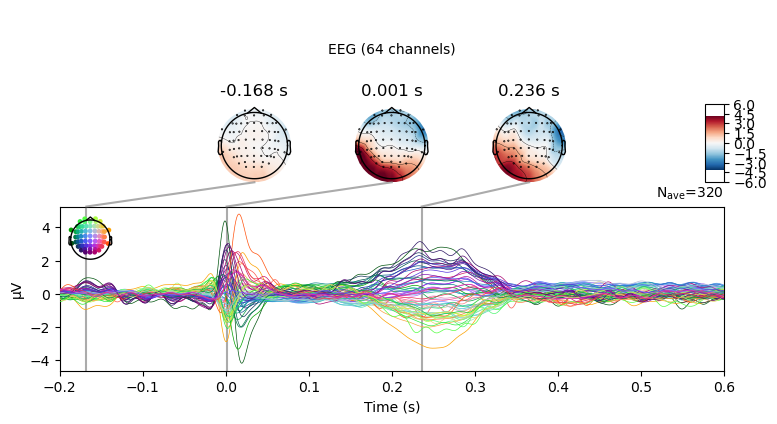

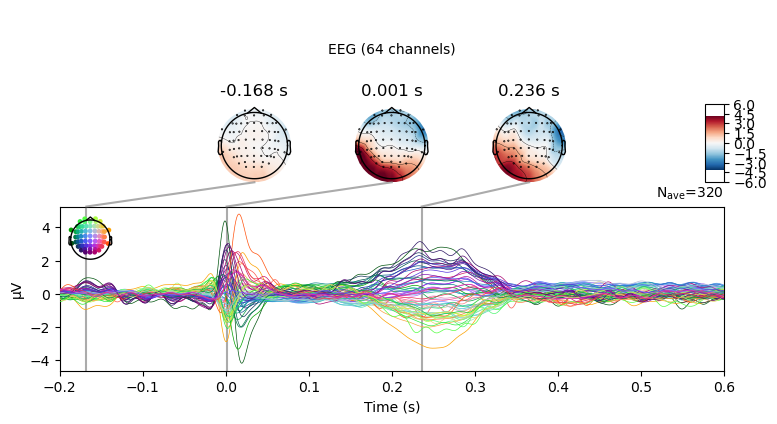

In [28]:
eog_first_epoch = mne.Epochs(eog_filt_firstrest,events = pan_tompkins_events, tmin= epoch_tmin, tmax = epoch_tmax, baseline = baseline, picks = ['eeg'])
eog_first_evoked = eog_first_epoch.average()
eog_first_evoked.plot_joint()

# hep_data_first_rest = eog_first_evoked.get_data()
# hep_data_first_rest = hep_data_first_rest.T

Not setting metadata
965 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


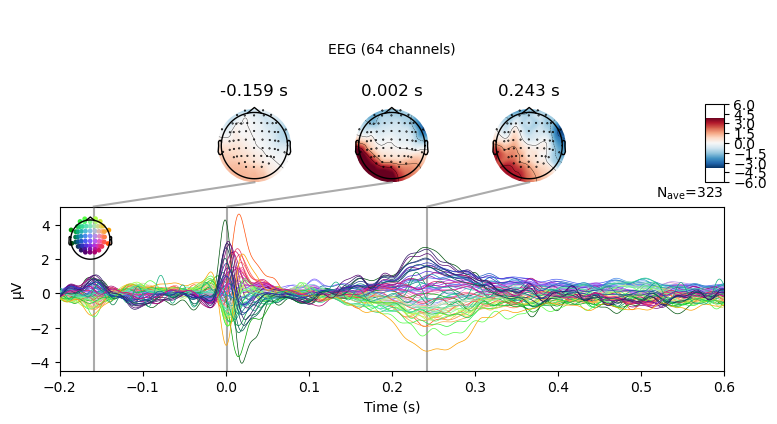

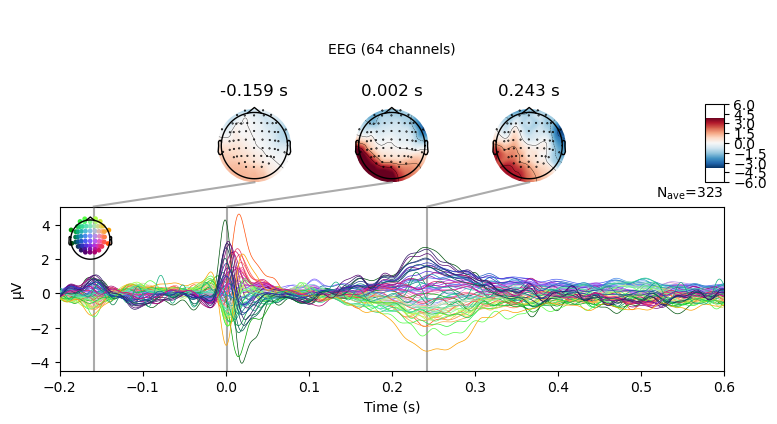

In [29]:
eog_stress_epoch = mne.Epochs(eog_filt_stress,events = pan_tompkins_events, tmin= epoch_tmin, tmax = epoch_tmax, baseline = baseline, picks = ['eeg'])
eog_stress_evoked = eog_stress_epoch.average()
eog_stress_evoked.plot_joint()

# hep_data_stress = eog_stress_evoked.get_data()
# hep_data_stress = hep_data_stress.T

Not setting metadata
965 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


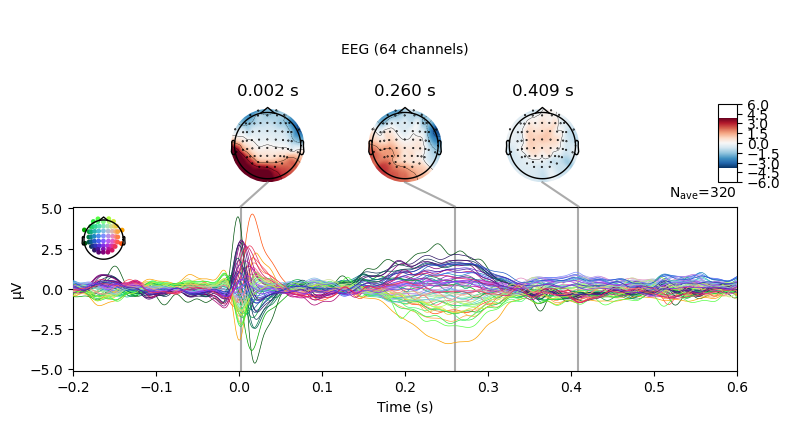

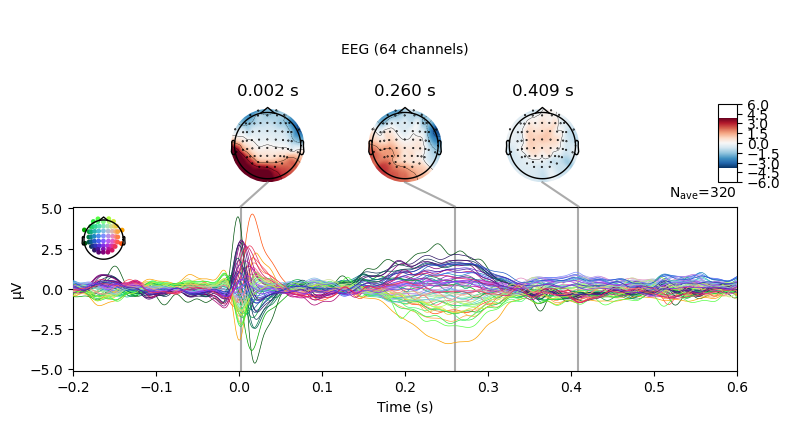

In [30]:
eog_second_epoch = mne.Epochs(eog_filt_secondrest,events = pan_tompkins_events, tmin= epoch_tmin, tmax = epoch_tmax, baseline = baseline, picks = ['eeg'])
eog_second_evoked = eog_second_epoch.average()
eog_second_evoked.plot_joint()

# hep_data_second_rest = eog_second_evoked.get_data()
# hep_data_second_rest = hep_data_second_rest.T

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


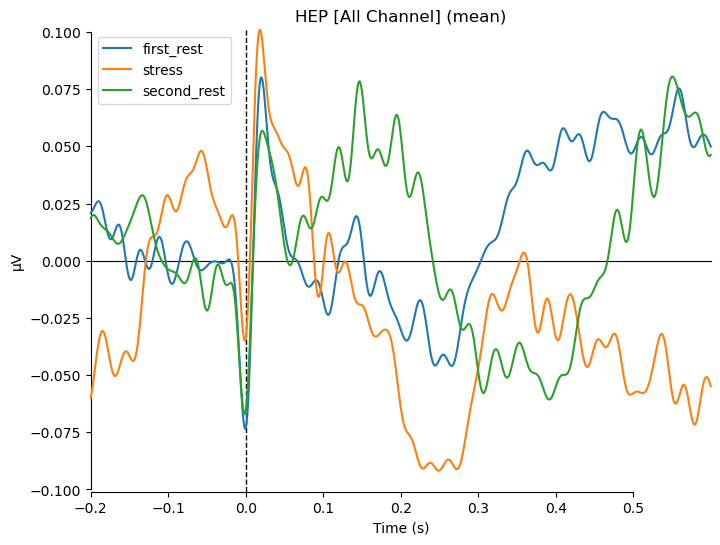

[<Figure size 800x600 with 1 Axes>]

In [31]:
evokeds = dict(first_rest = eog_first_evoked,stress = eog_stress_evoked,second_rest = eog_second_evoked)
mne.viz.plot_compare_evokeds(evokeds,title = 'HEP [All Channel]',combine="mean")

 ### CFA Derived Epoch Exctraction

In [18]:
cfa_filt_raw = reconst_raw_cfa.load_data().copy().filter(l_freq=1.0, h_freq=40, picks = ['eeg'])

cfa_filt_firstrest = cfa_filt_raw.copy().crop(tmin = 0, tmax = eeg_newseg1)
cfa_filt_stress = cfa_filt_raw.copy().crop(tmin = eeg_newseg1, tmax = eeg_newseg2)
cfa_filt_secondrest = cfa_filt_raw.copy().crop(tmin = eeg_newseg2)

cfa_first_epoch = mne.Epochs(cfa_filt_firstrest,events = pan_tompkins_events, tmin= epoch_tmin, tmax = epoch_tmax, baseline = baseline, picks = ['eeg'])
cfa_stress_epoch = mne.Epochs(cfa_filt_stress,events = pan_tompkins_events, tmin= epoch_tmin, tmax = epoch_tmax, baseline = baseline, picks = ['eeg'])
cfa_second_epoch = mne.Epochs(cfa_filt_secondrest,events = pan_tompkins_events, tmin= epoch_tmin, tmax = epoch_tmax, baseline = baseline, picks = ['eeg'])

Reading 0 ... 900501  =      0.000 ...   900.501 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
965 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
965 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
965 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


#### CFA Evoked Comparison

Not setting metadata
965 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


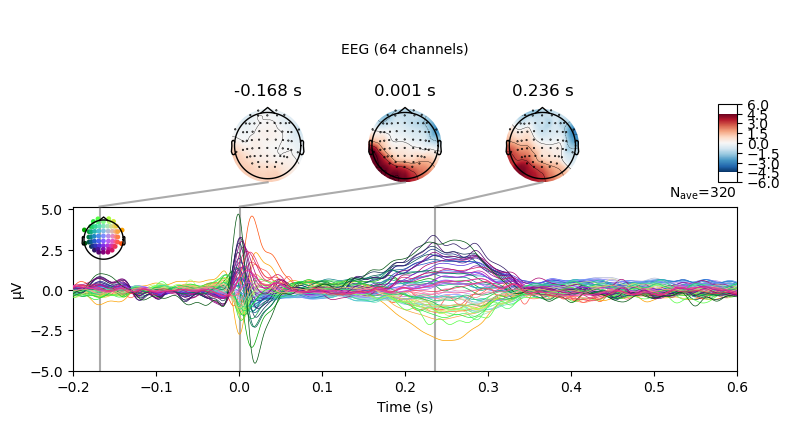

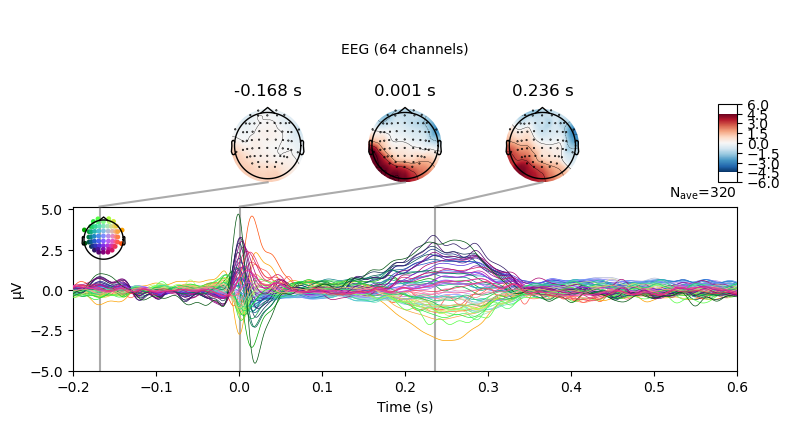

In [19]:
cfa_first_epoch = mne.Epochs(cfa_filt_firstrest,events = pan_tompkins_events, tmin= epoch_tmin, tmax = epoch_tmax, baseline = baseline, picks = ['eeg'])
cfa_first_evoked = cfa_first_epoch.average()
cfa_first_evoked.plot_joint()

# hep_data_first_rest = cfa_first_evoked.get_data()
# hep_data_first_rest = hep_data_first_rest.T

Not setting metadata
965 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


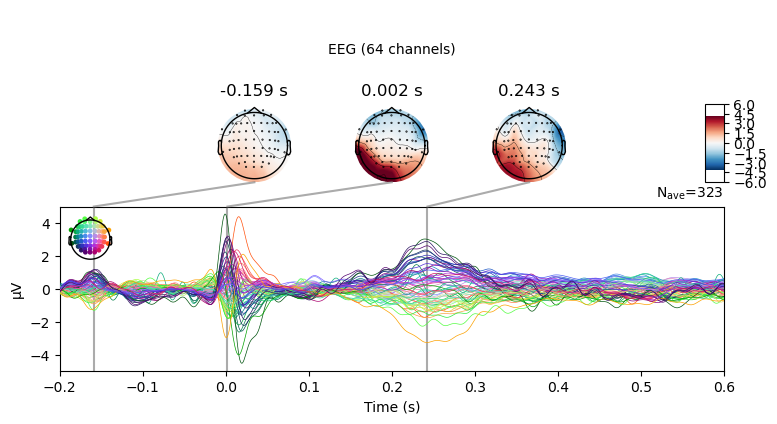

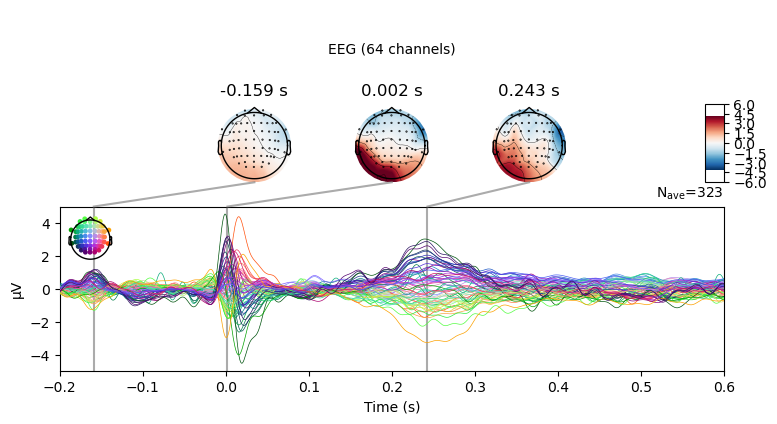

In [20]:
cfa_stress_epoch = mne.Epochs(cfa_filt_stress,events = pan_tompkins_events, tmin= epoch_tmin, tmax = epoch_tmax, baseline = baseline, picks = ['eeg'])
cfa_stress_evoked = cfa_stress_epoch.average()
cfa_stress_evoked.plot_joint()

# hep_data_stress = cfa_stress_evoked.get_data()
# hep_data_stress = hep_data_stress.T

Not setting metadata
965 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


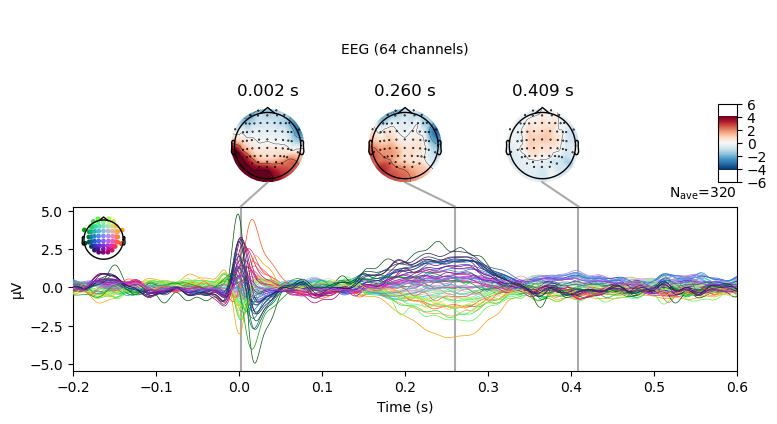

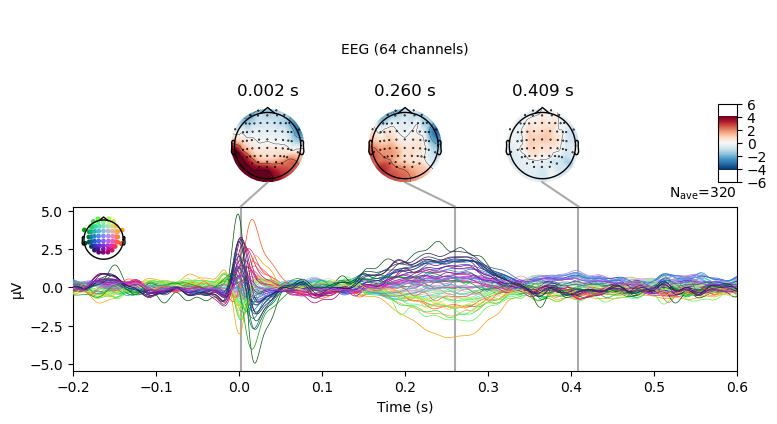

In [21]:
cfa_second_epoch = mne.Epochs(cfa_filt_secondrest,events = pan_tompkins_events, tmin= epoch_tmin, tmax = epoch_tmax, baseline = baseline, picks = ['eeg'])
cfa_second_evoked = cfa_second_epoch.average()
cfa_second_evoked.plot_joint()

# hep_data_second_rest = cfa_second_evoked.get_data()
# hep_data_second_rest = hep_data_second_rest.T

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


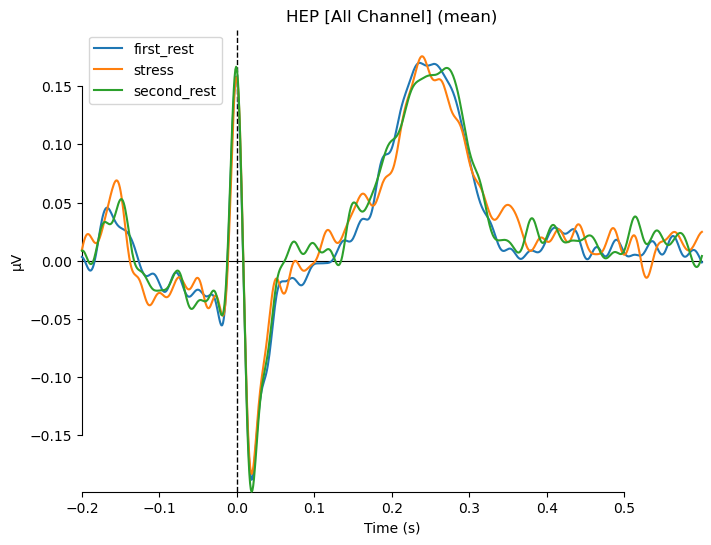

[<Figure size 800x600 with 1 Axes>]

In [22]:
evokeds = dict(first_rest = cfa_first_evoked,stress = cfa_stress_evoked,second_rest = cfa_second_evoked)
mne.viz.plot_compare_evokeds(evokeds,title = 'HEP [All Channel]',combine="mean")

### ASR Epoch Extraction

In [ ]:
asr_epoch = mne.Epochs(raw_asr,events = pan_tompkins_events, tmin= epoch_tmin, tmax = epoch_tmax, baseline = baseline, picks = ['eeg'])


## Extraction

Extract Filtered EEG Signals

In [ ]:
reconst_raw_eog.save(os.path.join(folder_filtered_eog,file_name.replace(".vhdr", "-ica.fif")), overwrite=True)
reconst_raw_cfa.save(os.path.join(folder_filtered_cfa,file_name.replace(".vhdr", "-ica.fif")), overwrite=True)
raw_asr.save(os.path.join(folder_filtered_asr,file_name.replace(".vhdr", "-ica.fif")), overwrite=True)

Extract HEP Signals

In [ ]:
eog_first_epoch.save(os.path.join(folder_epoch_eog,file_name.replace(".vhdr", "-first-epo.fif")), overwrite=True)
eog_stress_epoch.save(os.path.join(folder_epoch_eog,file_name.replace(".vhdr", "-stress-epo.fif")), overwrite='True')
eog_second_epoch.save(os.path.join(folder_epoch_eog,file_name.replace(".vhdr", "-second-epo.fif")), overwrite='True')

In [ ]:
cfa_first_epoch.save(os.path.join(folder_epoch_cfa,file_name.replace(".vhdr", "-first-epo.fif")), overwrite='True')
cfa_stress_epoch.save(os.path.join(folder_epoch_cfa,file_name.replace(".vhdr", "-stress-epo.fif")), overwrite='True')
cfa_second_epoch.save(os.path.join(folder_epoch_cfa,file_name.replace(".vhdr", "-second-epo.fif")), overwrite='True')

## Unused

### EEG Data - ICA Method

In [ ]:
raw_temp = raw.copy().crop(tmin = tmin, tmax = tmax) #make a copy
raw_temp.load_data()

In [ ]:
ica = read_ica(fname=fpath.replace(".vhdr", "-ica.fif"))

In [ ]:
filt_raw = raw_temp.load_data().copy().filter(l_freq=1.0, h_freq=None)

ic_labels = label_components(filt_raw, ica, method="iclabel")
print(ic_labels["labels"])

In [ ]:
labels = ic_labels["labels"]
eog_indices = [idx for idx, label in enumerate(labels) if label in ["eye blink"]]
eog_cfa_indices = [idx for idx, label in enumerate(labels) if label in ["eye blink","heart beat"]]

In [ ]:
# ica.exclude = [0, 3, 18, 19, 10, 11, 15,26,27, 29, 24, 30, 9, 23,31]
# ica.exclude = [0, 3, 17, 19, 15, 29, 30]
ica.exclude = eog_indices
reconst_raw_eog = raw_temp.copy()
ica.apply(reconst_raw_eog)

ica.exclude = eog_cfa_indices
reconst_raw_cfa = raw_temp.copy()
ica.apply(reconst_raw_cfa)

### EEG Data - ASR Method

In [ ]:
raw_asr = raw_temp.copy().pick_types(eeg=True, ecg=False, eog=False).crop(tmin=0, tmax=300).filter(l_freq=1.0, h_freq=40, picks = ['eeg'])

In [ ]:
asr = asrpy.ASR(sfreq=raw_asr.info["sfreq"], cutoff=5)
asr.fit(raw_asr)
raw_asr = asr.transform(raw_asr)

NameError: name 'raw_asr' is not defined

## Others

In [23]:
raw_filtered = mne.io.read_raw_fif(os.path.join(folder_filtered_eog,file_name.replace(".vhdr", "-ica.fif")))

Opening raw data file filtered_data_ica_eog\20231019_B68_stroop5mins_0001-ica.fif...
    Range : 39471 ... 939972 =     39.471 ...   939.972 secs
Ready.


C:\Users\jeje_\AppData\Local\Temp\ipykernel_17804\3925071567.py:1: RuntimeWarning: This filename (filtered_data_ica_eog\20231019_B68_stroop5mins_0001-ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filtered = mne.io.read_raw_fif(os.path.join(folder_filtered_eog,file_name.replace(".vhdr", "-ica.fif")))


In [24]:
raw.plot(title='raw')

In [25]:
raw_filtered.plot(title='raw cfa removed')

Channels marked as bad:
none
